In [128]:
# Import common libraries
import pandas as pd
import numpy as np
from copy import deepcopy
import importlib


# Import MNE processing
from mne.viz import plot_compare_evokeds
from mne import Epochs, events_from_annotations, set_log_level
from mne_nirs.visualisation import plot_glm_group_topo

# Scikit Learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from mne_nirs.statistics import run_glm
import matplotlib as mpl

# Internal Packages
import analysis_tools
import system_file_io
import quality_eval
import dynamic_interval_tools
import glm_analysis
import visualizations

# Reset the cache
importlib.reload(analysis_tools)
importlib.reload(system_file_io)
importlib.reload(dynamic_interval_tools)
importlib.reload(glm_analysis)
importlib.reload(visualizations)

<module 'visualizations' from '/Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/visualizations.py'>

In [129]:
# ------------------------------------------------------------------
# Recurring values that we will allow for users to change in the GUI
# ------------------------------------------------------------------

# Length of the measured interval
interval_length = 15

# Time from trigger point being evaluated
# tmin = -1
# tmax = 15

# How you would like to rename the numeric triggers from Aurora
trigger_id = {'4': 'Control', '2': 'Neutral', '3': 'Inflam', '1':'Practice'}

# What files would you like to ignore while looping through subjects
ignore = [".DS_Store", "sub-03"]

# File path to the folder containing the BIDS data.
root_dir = '../../LabResearch/IndependentStudy/DataAnalysis'

# Mock data folder to test pulling meta data from folder structure.
path = "../../LabResearch/IndependentStudy/Data"

# Does the study have variable task lengths or does the study follow a block design?
variable_epoch_time = True

# Specifies what columns to use for the GLM constrast. If None, contrast is skipped
# Only two columns can be specified
columns_for_glm_contrast = ['Neutral', 'Inflam']

# Specifies what columns to use for group level analysis.
columns_for_group_analysis = ['Neutral', 'Inflam', 'Control']

In [130]:

def run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=None, tmax=None):
    # Establish the groups, subject names, and snirf file paths for all subjects
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}
    for group in groups:
        paths = df[df.eq(group).any(1)]['snirf_path'].to_numpy()

        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data = analysis_tools.aggregate_epochs(paths=paths, trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)

        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, tmin, tmax)

        # Converts the glm design matrixes into a dataframe
        df_cha, df_con = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(df_cha)

        glm_dataframes[group] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes

In [131]:
def run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=None, tmax=None):
    groups, df = system_file_io.import_data_folder(path, ignore)
    # run the analysis for each group
    glm_dataframes = {}

    paths = df[df.any(1)]['snirf_path'].to_numpy()

    for id, path in enumerate(paths):
        # Processes all Epochs with proper timestamps and collects it in all_epochs
        # all_data is dict of epoch, condition, raw_haemo, raw_intensity, and f_path for all subs
        all_epochs, all_data = analysis_tools.aggregate_epochs(paths=[path], trigger_id=trigger_id, variable_epoch_time = variable_epoch_time)

        # Process the GLM for all participants in the group into a list of design matrixes
        glm_data = glm_analysis.create_design_matrix(all_data, tmin, tmax)

        # Converts the glm design matrixes into a dataframe
        df_cha, df_con = glm_analysis.create_glm_df(glm_data, columns_for_glm_contrast)

        # Find the groups significant channels
        significant_channels = analysis_tools.find_significant_channels(df_cha)

        glm_dataframes[f'sub-{id+1}'] = {"channels_df": df_cha, "contrasts_df": df_con, "significant_channels": significant_channels, "all_data": all_data}
        
    return glm_dataframes

In [132]:
group_data = run_group_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis, tmin=tmin, tmax=tmax)
group_data

Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../LabResearch/IndependentStudy/Data/anon/sub-06/nirs/sub-06_task-AnonCom_nirs.snirf
Reading 0 ... 18357  =      0.000 ...  1804.493 secs...
Events [359   0   1]
[]
[]
[<Epochs |  1 events (all good), -1.25 - 47.5 sec, baseline -1.25 – 0 sec, ~170 kB, data loaded,
 'Practice': 1>]
[<Epochs |  1 events (all good), -1.25 - 47.5 sec, baseline -1.25 – 0 sec, ~170 kB, data loaded,
 'Practice': 1>]
[<Epochs |  1 events (all good), -1.25 - 47.5 sec, baseline -1.25 – 0 sec, ~170 kB, data loaded,
 'Practice': 1>, <Epochs |  1 events (all good), -1.25 - 47.5 sec, baseline -1.25 – 0 sec, ~170 kB, data loaded,
 'Practice': 1>]
[<Epochs |  1 events (all good), -1.25 - 47.5 sec, baseline -1.25 – 0 sec, ~170 kB, data loaded,
 'Practice': 1>, <Epochs |  1 events (all good), -1.25 - 47.5 sec, baseline -1.25 – 0 sec, ~170 kB, data loaded,
 'Practice': 1>]
[<Epochs |  1 events (all good), -1.25 - 47.5 sec, baseline -1.25 – 0 sec, ~170 kB, da

{'anon': {'channels_df': variable Condition    df           mse   p_value            se         t  \
  0          Control  41.0  1.732858e-11  0.017723  1.951074e-06 -2.470935   
  1           Inflam  41.0  1.732858e-11  0.514172  1.949191e-06 -0.658069   
  2          Neutral  41.0  1.732858e-11  0.219602  1.949475e-06  1.246649   
  3         Practice  41.0  1.732858e-11  0.226729  1.948336e-06 -1.227251   
  4         constant  41.0  1.732858e-11  0.806730  9.973465e-07  0.246234   
  ...            ...   ...           ...       ...           ...       ...   
  51403      drift_5  38.0  3.358008e-13  0.764509  4.188950e-06  0.301723   
  51404      drift_6  38.0  3.358008e-13  0.499899  4.145174e-06  0.681162   
  51405      drift_7  38.0  3.358008e-13  0.745477  4.118503e-06  0.326980   
  51406      drift_8  38.0  3.358008e-13  0.680340  4.094311e-06  0.415187   
  51407      drift_9  38.0  3.358008e-13  0.929713  4.073446e-06 -0.088793   
  
  variable         theta Source Detect

In [133]:
# individual_data = run_individual_analysis(path, ignore, variable_epoch_time, columns_for_glm_contrast, columns_for_group_analysis)
# individual_data

# Visualizations

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


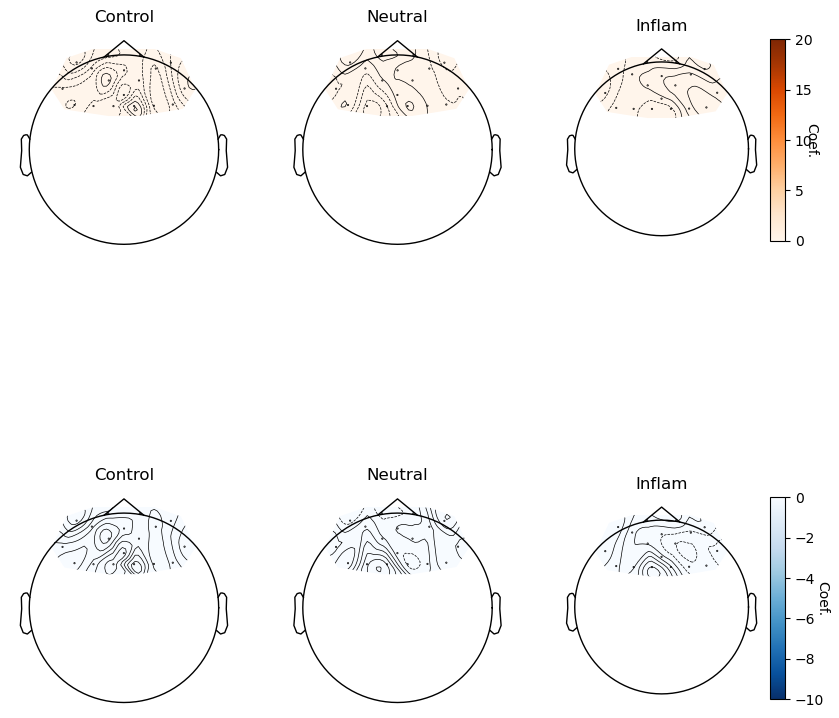

In [197]:
# Group Visualization
importlib.reload(visualizations)
columns_for_glm_contrast = ['Control', 'Neutral', 'Inflam']

channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()

raw_haemo = all_data[0]['raw_haemo']

visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo)

In [196]:
# Generate a summarized dataframe of the channels and conditions significance
importlib.reload(analysis_tools)
columns_for_glm_contrast = ['Control', 'Neutral', 'Inflam']

channels_df, contrasts_df, significant_channels, all_data = group_data['direct'].values()

raw_haemo = all_data[0]['raw_haemo']

ch_model_df = analysis_tools.create_results_dataframe(channels_df, columns_for_glm_contrast, raw_haemo)

ch_model_df['hbr']

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Coef. Std.Err.         z         P>|z|    [0.025  \
ch_name   Condition                                                            
S1_D1 hbr Control    2.051875e-07      0.0  0.622530  5.335931e-01      -0.0   
          Inflam     6.379554e-07      0.0  1.935531  5.292516e-02      -0.0   
          Neutral   -4.012697e-07      0.0 -1.217436  2.234383e-01 -0.000001   
S1_D2 hbr Control    9.551696e-07      0.0  2.897946  3.756149e-03       0.0   
          Inflam     4.450246e-07      0.0  1.350187  1.769561e-01      -0.0   
          Neutral    2.258259e-06      0.0  6.851466  7.309689e-12  0.000002   
S2_D1 hbr Control    6.399786e-07      0.0  1.941669  5.217713e-02      -0.0   
          Inflam     1.285279e-06      0.0  3.899484  9.639778e-05  0.000001   
          Neutral    7.196844e-07      0.0  2.183493  2.899949e-02       0.0   
S2_D3 hbr Control    2.145845e-06      0.0  6.510408  7.494712e-11  0.000001   
          Inflam     1.287043e-06      0.0  3.904837  9.428903e-05  0.000001   
          Neutral   -8.119799e-07      0.0 -2.463514  1.375824e-02 -0.000001   
S3_D3 hbr Control    9.413303e-07      0.0  2.855958  4.290713e-03       0.0   
          Inflam     1.646887e-07      0.0  0.499659  6.173152e-01      -0.0   
          Neutral    4.855268e-07      0.0  1.473069  1.407325e-01      -0.0   
S3_D4 hbr Control   -9.894573e-08      0.0 -0.300197  7.640266e-01 -0.000001   
          Inflam    -3.560041e-08      0.0 -0.108010  9.139876e-01 -0.000001   
          Neutral    8.141813e-08      0.0  0.247019  8.048933e-01 -0.000001   
S4_D2 hbr Control    1.718515e-06      0.0  5.213906  1.849054e-07  0.000001   
          Inflam     2.028991e-06      0.0  6.155878  7.466281e-10  0.000001   
          Neutral    2.369722e-06      0.0  7.189640  6.496245e-13  0.000002   
S4_D4 hbr Control    1.747385e-06      0.0  5.301495  1.148583e-07  0.000001   
          Inflam     2.288777e-07      0.0  0.694406  4.874278e-01      -0.0   
          Neutral   -3.070748e-07      0.0 -0.931653  3.515161e-01 -0.000001   
S4_D5 hbr Control   -1.596924e-07      0.0 -0.484500  6.280309e-01 -0.000001   
          Inflam     5.678910e-07      0.0  1.722958  8.489604e-02      -0.0   
          Neutral   -6.738192e-07      0.0 -2.044340  4.091993e-02 -0.000001   
S5_D3 hbr Control    1.110627e-06      0.0  3.369596  7.527840e-04       0.0   
          Inflam     2.408060e-07      0.0  0.730596  4.650261e-01      -0.0   
          Neutral   -8.131812e-07      0.0 -2.467159  1.361899e-02 -0.000001   
S5_D4 hbr Control    5.724450e-07      0.0  1.736775  8.242688e-02      -0.0   
          Inflam    -4.306745e-07      0.0 -1.306649  1.913319e-01 -0.000001   
          Neutral    3.604827e-08      0.0  0.109369  9.129098e-01 -0.000001   
S5_D6 hbr Control    9.970686e-07      0.0  3.025066  2.485787e-03       0.0   
          Inflam     5.780603e-07      0.0  1.753812  7.946279e-02      -0.0   
          Neutral   -3.215872e-07      0.0 -0.975683  3.292218e-01 -0.000001   
S6_D4 hbr Control    9.481492e-07      0.0  2.876646  4.019257e-03       0.0   
          Inflam    -9.701202e-07      0.0 -2.943306  3.247276e-03 -0.000002   
          Neutral    9.178544e-08      0.0  0.278473  7.806490e-01 -0.000001   
S6_D6 hbr Control    1.306670e-06      0.0  3.964384  7.358574e-05  0.000001   
          Inflam    -5.846453e-07      0.0 -1.773790  7.609782e-02 -0.000001   
          Neutral    4.011734e-07      0.0  1.217144  2.235494e-01      -0.0   
S7_D5 hbr Control    1.293110e-06      0.0  3.923243  8.736491e-05  0.000001   
          Inflam    -8.028869e-07      0.0 -2.435927  1.485370e-02 -0.000001   
          Neutral   -1.761610e-07      0.0 -0.534465  5.930195e-01 -0.000001   
S7_D7 hbr Control    1.030910e-06      0.0  3.127739  1.761563e-03       0.0   
          Inflam    -8.126602e-07      0.0 -2.465579  1.367922e-02 -0.000001   
          Neutral    1.109593e-06      0.0  3.366461  7.613939e-04       0.0   
S8_D6 hbr Control    9.59645

In [ ]:
# Individual Visualization
importlib.reload(visualizations)
channels_df, contrasts_df, significant_channels, all_data = individual_data['sub-1'].values()

raw_haemo = all_data[0]['raw_haemo']

visualizations.group_topological_visualisation(channels_df, columns_for_glm_contrast, raw_haemo)